# 中文预训练词向量

自从Word2Vec词向量训练技术公开以后，有大量的企业或团队通过海量文本语料做了词向量的训练，并开放给用户使用。我们可以以[腾讯开放的中文词向量](https://ai.tencent.com/ailab/nlp/embedding.html)为例，看一下这些预训练词向量的使用。


腾讯开源的词向量是腾讯AI Lab用了海量语料训练的中文词向量，包含有880万个中文词汇（具体是8824330），每个词有200维，相比腾讯发表这个词向量数据之前的其他公开中文词向量数据，腾讯AI Lab的中文词向量着重提升了以下3个方面，相比已有各类中文词向量大大改善了其质量和可用性：

⒈ 覆盖率（Coverage）：

该词向量数据包含很多现有公开的词向量数据所欠缺的短语，比如“不念僧面念佛面”、“冰火两重天”、“煮酒论英雄”、“皇帝菜”、“喀拉喀什河”等。以“喀拉喀什河”为例，利用腾讯AI Lab词向量计算出的语义相似词如下：

墨玉河、和田河、玉龙喀什河、白玉河、喀什河、叶尔羌河、克里雅河、玛纳斯河

⒉ 新鲜度（Freshness）：

该数据包含一些最近一两年出现的新词，如“恋与制作人”、“三生三世十里桃花”、“打call”、“十动然拒”、“供给侧改革”、“因吹斯汀”等。以“因吹斯汀”为例，利用腾讯AI Lab词向量计算出的语义相似词如下：

一颗赛艇、因吹斯听、城会玩、厉害了word哥、emmmmm、扎心了老铁、神吐槽、可以说是非常爆笑了

⒊ 准确性（Accuracy）：

由于采用了更大规模的训练数据和更好的训练算法，所生成的词向量能够更好地表达词之间的语义关系，如下列相似词检索结果所示：
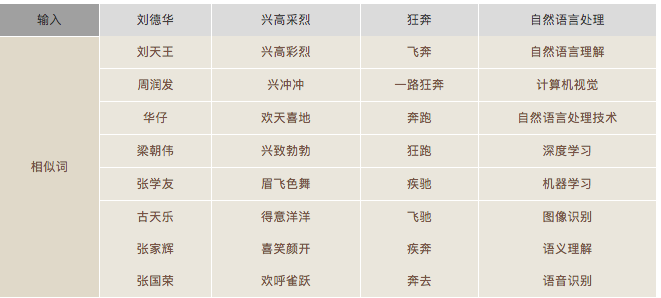

我们在腾讯的网站上下载词向量文件的压缩包并在本地解压以后，得到一个大约16G的Tencent_AILab_ChineseEmbedding.txt文件，这就是腾讯词向量文件了，它采用的文件格式是word2vec文件格式，即类似如下的格式：

5 4  

是 -0.119938 0.042054504 -0.02282253 -0.10101332  

中国人 0.080497965 0.103521846 -0.13045108 -0.01050107  

你 -0.0788643 -0.082788676 -0.14035964 0.09101376  

我 -0.14597991 0.035916027 -0.120259814 -0.06904249  

其中第一行表示此文件中有多少单词，每个单词的词向量维度是多少，在上面的例子中即5个单词，每个单词的词向量维度是4
然后其他每一行都代表一个词向量，第一列是单词，其他列就是这个单词的词向量了。

下面我们来用代码演示一下，可以用这个词向量文件来进行一些有趣的操作。首先我们进行相似词的查询，考虑到腾讯预训练词向量的大小，直接使用gensim的similar_words进行暴力计算显然性能很差的（要跟800万个向量进行比对计算），所以我们用Annoy进行向量索引，加快向量检索的速度。下面的代码分为两部分，第一部分是用腾讯的词向量文件构建一些索引文件和映射文件，需要较大的内存，过程也需要比较长的时间。但一旦构建好索引和映射文件，就可以用这些索引和映射文件来查询了。所以如果你没有大量内存，可以跳过第一部分，直接用构建好的索引和映射文件来运行第二部分。

## 读取词向量文件构建Annoy索引

我们首先用gensim读取此词向量文件：

In [ ]:
import time
from gensim.models import KeyedVectors
# 加载预训练的腾讯词向量模型
# 此处加载时间较长，在24G内存的机器上大概运行了20分钟，加载完毕后大概使用了12G内存，后续使用过程中内存还在增长
start = time.time()
tc_wv_model = KeyedVectors.load_word2vec_format('/input/Tencent_AILab_ChineseEmbedding.txt', binary=False)
stop = time.time()

print("time for loading tencent word vectors = %.2f s" % (float(stop - start)))

然后，我们构建一份单词到ID的映射表和一份ID到单词的映射表，并把这个映射表存储成json文件保存下来，方便以后离线加载annoy索引时使用

In [ ]:
import json
from collections import OrderedDict

# 构建一份词汇ID映射表，并以json格式离线保存一份（这个方便以后离线直接加载annoy索引时使用）
word_index = OrderedDict()

for counter, key in enumerate(tc_wv_model.vocab.keys()):
    word_index[key] = counter

with open('tc_word_index.json', 'w') as fp:
    json.dump(word_index, fp)

# 准备一个反向id==>word映射词表
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 

然后我们用annoy来构建索引，并把索引保存下来，以后用构建好的索引文件来查询相似词。

In [ ]:
# 开始基于腾讯词向量构建Annoy索引，腾讯词向量大概是882万条
from annoy import AnnoyIndex


# 腾讯词向量的维度是200
tc_index = AnnoyIndex(200)

i = 0
start = time.time()

for key in tc_wv_model.vocab.keys():
    v = tc_wv_model[key]
    tc_index.add_item(i, v)
    i += 1

stop = time.time()

print("time for add items into annoy index = %.2f s" % (float(stop - start)))

start = time.time()
# 这个构建时间也比较长，另外n_trees这个参数很关键，官方文档是这样说的：
# n_trees is provided during build time and affects the build time and the index size. 
# A larger value will give more accurate results, but larger indexes.
# 这里按文档里的是10设置，到此整个流程的内存占用大概是30G左右    
tc_index.build(10)    

stop = time.time()

print("time for building annoy index = %.2f s" % (float(stop - start)))

# 将这份index存储到硬盘上,以后只需要这个索引文件即可，无需再加载词向量文件本身
fname = 'tc_index_build10.ann.index'
tc_index.save(fname)

## 使用索引进行词向量近似查询

在构建好索引和映射文件以后，我们可以不再使用词向量文件和gensim模型，而直接使用annoy索引进行相近单词的查询。

下面首先读取映射文件，并构建反向映射:

In [ ]:
import time
import json
from collections import OrderedDict

with open('tc_word_index.json', 'r') as fp:
    word_index = json.load(fp)

#准备一个反向id==>word映射词表
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])   

然后我们从上一步构建好的索引文件中恢复annoy索引:·

In [ ]:
from annoy import AnnoyIndex

fname = 'tc_index_build10.ann.index'

# 我们用保存好的索引文件重新创建一个Annoy索引, 单独进行加载
annoy_index = AnnoyIndex(200)
annoy_index.load(fname)

现在我们就可以用这个索引和单词映射，进行相近单词的查询了：

In [ ]:
start = time.time()

queries = word_index['身份证明']

id, score = annoy_index.get_nns_by_item(queries, 20, include_distances=True)

result =[(reverse_word_index[i],0.5*(abs(1-j))+0.5) for i,j in zip(id,score)]

print(result)

stop = time.time()

print("time for query one similar word = %.2f s" % (float(stop - start)))

可以看到，使用了annoy索引以后，在800万个词向量中查询一个单词的近似词向量，查询速度还是很快的（在我的笔记本上用CPU查询速度可以达到10ms）。需要说明的是，最后那个0.5*(abs(1-j))+0.5是余弦相似度归一化的计算公式，annoy中建立的距离索引以及最后查找返回值都是默认angular模式（即j的值），也即是余弦相似度，即angular=1-cosin，且其值域为[0,2]（因为cosin值域为[-1,1]）。但是我们通常希望将向量之间的距离值域取为[0,1]，所以我们先用1-angular 获取cosin 然后再求取绝对值，最后再进行归一化即可。

## 未登录词的查询

不过，如果我们查询词典之外的词（即800万个单词以外的单词，术语是未登录词，OOV），就没办法查到了，比如“二胎生育证”在词典中，而"二胎生育证明”就不在词汇表中，所以无法查到相似词。如果我们想查询所有中文词汇的词向量的话，可以用FastText的思想，把词典之外的词分成字，构建若干个N Gram，然后用这些Ngram的字组合的平均词向量，当做这个未登录词向量进行查找：

首先定义一个函数，可以产生未登录词的N-gram组合:

In [ ]:
import numpy as np

def compute_ngrams(word, min_n=1, max_n=3):
    extended_word =  word
    ngrams = []
    for ngram_length in range(min_n, min(len(extended_word), max_n) + 1):
        for i in range(0, len(extended_word) - ngram_length + 1):
            ngrams.append(extended_word[i:i + ngram_length])
    return list(set(ngrams))

In [ ]:
compute_ngrams('二胎生育证明',min_n = 1,max_n = 3)

然后我们定义未登录词的近似词查询方法：

In [ ]:
def queryOOVSimilarWords(word,word2index,index2word,annoy_index,word_dim=200,k=20):    
    # 计算word的ngrams词组
    ngrams = compute_ngrams(word,min_n = 1, max_n = len(word)-1)    
    
    # 使用这个词向量代表未登录词，先初始化为0
    word_vec = np.zeros(word_dim, dtype=np.float32)
    
    ngrams_found = 0
    ngrams_single = [ng for ng in ngrams if len(ng) == 1]
    ngrams_more = [ng for ng in ngrams if len(ng) > 1]
    
    # 先搜索2个单词长度以上的词向量
    for ngram in ngrams_more:
        if ngram in word2index.keys():
            word_vec += annoy_index.get_item_vector(word2index[ngram])
            ngrams_found += 1
            #print(ngram)
    # 如果没有匹配到，那么再考虑单字词向量
    if ngrams_found == 0:
        for ngram in ngrams_single:
            word_vec += annoy_index.get_item_vector(word2indexindex[ngram])
            ngrams_found += 1
    
    if word_vec.any():
        word_vec = word_vec / max(1, ngrams_found)
        similar_indices = annoy_index.get_nns_by_vector(word_vec, k, include_distances=False)
        similar_words = []
        for id in similar_indices:
            similar_words.append(index2word[id])        
        return similar_words
    else:
        raise KeyError('all ngrams for word %s absent from model' % word) 

In [ ]:
similarwords = queryOOVSimilarWords("二胎生育证明",word2index=word_index,
                                    index2word=reverse_word_index,annoy_index=annoy_index)  

print(similarwords)

可以看到，使用N-Gram近似以后查询到的近似词向量，与查询的未登录词还是比较相近的。

## 寻找一组词的相似词

有时，我们手上有一组词，希望找到与这组词相关的词。比如我们手上有若干个国家的首都，希望能够找到更多的首都，或者手上有某个单词的若干个同义词，希望能够找到更多的同义词。得益于线性性质，我们可以将这个组词的词向量进行平均，然后在词典中寻找与平均向量相似的词向量即可：

In [ ]:
import numpy as np

queries = ['北京','东京','巴黎','华盛顿','曼谷','伦敦']


start = time.time()

average_vec = np.mean( [annoy_index.get_item_vector(word_index[query]) for query in queries], axis=0)

id, score = annoy_index.get_nns_by_vector(average_vec, 20, include_distances=True)

result =[(reverse_word_index[i],0.5*(abs(1-j))+0.5) for i,j in zip(id,score)]

print(result)

stop = time.time()

print("time for query one similar word = %.2f s" % (float(stop - start)))

# 使用预训练词向量进行句子语义匹配

句子语义匹配任务简单来说，就是给出两个句子，判断这两个句子是否属于相同的意图，比如以下两个句子：
1. 怎么更改花呗手机号码		
2. 我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号

虽然表达方式不一样，但从语义(意图)来说是相同的，都是在咨询如何更改花呗手机号码的问题。如果我们在两个输入句子语义相同时输出1，语义不同时输出0，很明显这是一个 NLP 领域的分类问题，然而区别于传统的文本分类问题：

|区别|传统文本分类|句子语义匹配|
|-|-|-|
|输入|只有一个输入|有两个输入|
|特征|文本特征|语义特征|

句子语义匹配是智能客服的核心技术点之一，也是自动问答、聊天机器人、信息检索等应用的基础技术。在实际的智能客服应用中，用户经常会咨询各类问题，假如我们有一个事先准备好的FAQ集合，即包含很多问题/答案对，那么当用户咨询一个问题时，我们只需要将用户的问题与FAQ集合中所有问题答案对中的问题进行匹配，然后取出匹配成功的问题答案对中的答案回复给客户即可完成一问一答的交互。

国外较有影响力的句子语义匹配语料是Quora（国外的社区，类似国内的知乎）举办的句子语义匹配比赛，而近两年来，国内也举办了多次相关的比赛，如：

* [第三届魔镜杯问题相似度算法设计大赛](https://ai.ppdai.com/mirror/goToMirrorDetail?mirrorId=1)
* [微众银行智能客服问句匹配大赛(简称CCKS)](https://github.com/zoulala/CCKS_QA)
* [ATEC蚂蚁金服金融智能NLP服务大赛(简称ATEC)](https://dc.cloud.alipay.com/index#/topic/intro?id=8)

目前，中文句子语义匹配最大的开放语料，是[哈工大提供的LCQMC](https://www.aclweb.org/anthology/C18-1166/)语料，构建方式是针对不同的领域，从百度问答中抽取高频的相关问题，然后进行机器+人工筛选和标注，数据集有约26万对标注数据。匹配类型大致可以分为相同意图、精炼、习语转换、同义、重组这五种，如：

|编号|类别|示例|
|-|-|-|
|1|相同意图|有谁吃过完美的产品吗？如何<br>  完美产品好不好|
|2|精炼|朱熹是哪个朝代的诗人<br>  朱熹是宋明理学的集大成者，他生活在哪个朝代|
|3|习语转换|这是哪个奥特曼<br> 这是什么奥特曼|
|4|同义|网上找工作可靠吗<br>网上找工作靠谱吗|
|5|重组|你们都喜欢火影忍者里的谁啊<br>火影忍者里你最喜欢谁|




在datasets\sentence-similarity-zoo-master\data目录下，已经下载了ATEC, CCKS和LCQMC数据集，并按照train:dev:test 8:1:1的比例进行了划分，如train.tsv文件中，就包含了训练数据，格式如下:

开初婚未育证明怎么弄？	初婚未育情况证明怎么开？	1  
谁知道她是网络美女吗？	爱情这杯酒谁喝都会醉是什么歌	0  


每一行代表一个数据，每一行数据之间用Tab键间隔，前两部分是句子1和句子2， 后面的1代表两个句子可以匹配，0则代表两个句子不能匹配

## 模型设计

这里使用一个比较简单的模型来完成这个任务，如下图所示：

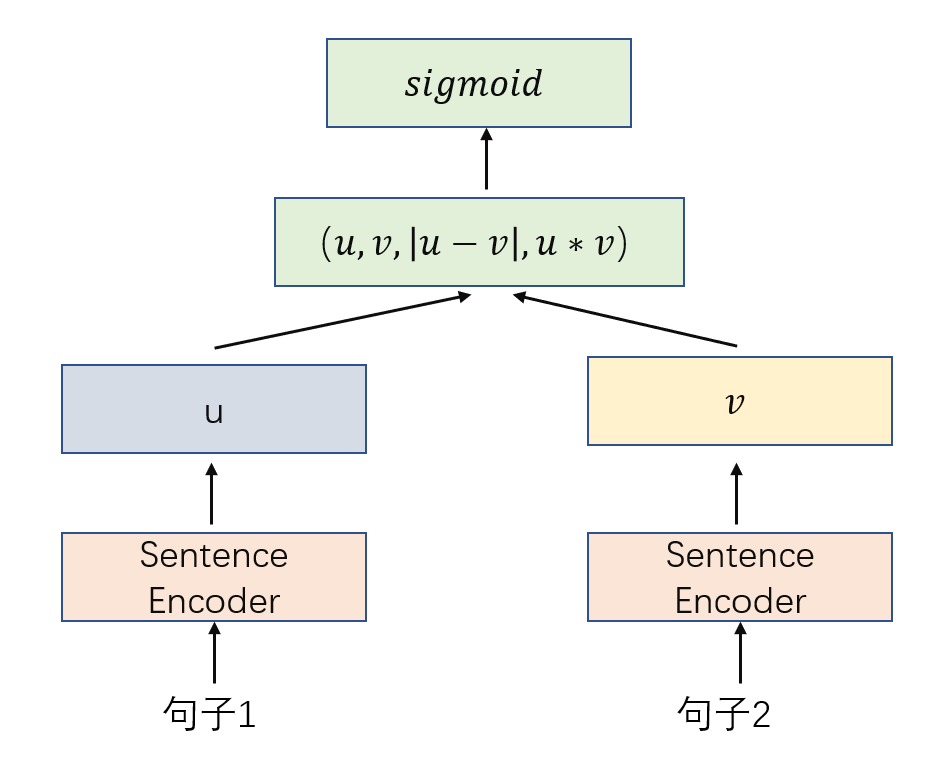

上图中，两个需要匹配的句子（句子1和句子2）分别通过句子编码器，从文本变成embedding向量$u和v$（句子向量而不是词向量，具体如何从句子转换成向量在下一节会介绍），该向量会代表对应的句子。然后我们采用2017年一篇颇有影响力的论文提出的[InferSent](https://arxiv.org/pdf/1705.02364.pdf)(这篇论文提出了一个通用的句子编码器）中提出的特征，将$u,v和u-v,u*v$组合起来,形成一个新的向量，然后通过一个全连接，输出sigmoid值，代表两个句子是否匹配的概率。

这个模型的设计实现非常简单：

In [2]:
from keras import Input, Model
from keras import backend as K
from keras.layers import Lambda, Dense
from keras.layers import concatenate, multiply, Dense

Using TensorFlow backend.


In [3]:
def build_model(dim_size=200,dense_unit=100):
    u_input = Input(shape=(dim_size,), dtype='float32', name="left_x")
    v_input = Input(shape=(dim_size,), dtype='float32', name='right_x')
    
    u_sub_v = Lambda(lambda x: K.abs(x[0] - x[1]))([u_input, v_input])
    u_mul_v = multiply([u_input, v_input])
    
    u_concat_v = concatenate([u_input, v_input, u_sub_v, u_mul_v])
    
    dense = Dense(dense_unit, activation='relu')(u_concat_v)
    similarity = Dense(1, activation='sigmoid')(dense)
    
    model = Model([u_input, v_input], similarity)
    #print(model.summary())
    return model

我们用Adam优化器来优化这个模型，学习率为1e-3, 训练32个轮次，采用在验证集上性能最好的作为最后的模型：

In [4]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report

In [5]:
def train_model(model, train_x, train_y, dev_x, dev_y,checkpointpath,lr=1e-3,batch_size=128,epochs=32):
    adam = Adam(lr=lr)
    model.compile(loss='binary_crossentropy',
                       optimizer=adam,
                       metrics=['accuracy'])    
    checkpoint_callback = ModelCheckpoint(checkpointpath,
                                          monitor='val_acc',
                                          verbose=0,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='auto',
                                          period=1)
    model.fit(train_x, train_y,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(dev_x, dev_y),
               shuffle=True,
               verbose=0,
               callbacks=[checkpoint_callback])


再定义一个预测方法，使用训练好的模型在测试集上进行预测：

In [6]:
def model_predict(model, test_x, test_y=None,predict_batchsize=128):
    
    predict_y = model.predict(test_x, batch_size=predict_batchsize)[:, 0]
    if test_y.any():
        predict_y[predict_y >= 0.5] = 1
        predict_y[predict_y < 0.5] = 0
        print(classification_report(test_y, predict_y))

## 句子嵌入编码


词向量解决的问题是从单词（或者更准确地说是Token）到向量的编码，但在实际的自然语言处理任务中，常见的任务对象是句子而非单词。因此，如何对句子进行嵌入式编码，成为一个自然语言处理任务中的关键问题。人们也为此做了很多研究，提出了非常多的方法，大致可以分为有监督和无监督两类。一般来讲如果我们需要的是比较generalized，能够用在各种task中的句子embedding， 无监督方法是一个更好的选择，因为它不太容易受到特定的NLP任务的影响。在无监督的方法中，有一种简单的编码方法是通过词向量，产生出句子的向量。

最简单的从词向量产生句子向量的方法，就是将句子中的所有单词向量加起来，然后求平均（除以句子中单词长度），就可以得到该句子的向量表示。虽然这种方法看起来太简单，但可以作为一个不错的baseline, 而且在很多下游任务（如句子分类、信息检索等）可以取得相当不错的效果。

发表2016年的论文 [A simple but tough-to-beat baseline for sentence embeddings](https://openreview.net/pdf?id=SyK00v5xx)提出了一种非常简单但很有效的从词向量产生句子向量的方法，这个被称为SIF( (smooth inverse frequency)的算法只包括两步，第一步是对句子中所有的词向量，根据每个单词的词频进行加权平均，得到平均向量vs；第二步是减去vs在所有句子向量组成的矩阵的第一个主成分(principal component / singular vector)上的投影。

在第一步计算每个单词加权平均的权重时，词$w$的权重为$\frac{\alpha}{\alpha+p(w)}$，其中$a$为平滑参数，$p(w)$为（估计的）词频。直观理解SIF，就是说频率越低的词在当前句子出现了，说明它在句子中的重要性更大，也就是加权系数更大。

对于第二步，直观理解是移出所有句子的共有信息，因此保留下来的句子向量更能够表示本身并与其它句子向量产生差距。




[实验](https://nlp.town/blog/sentence-similarity/)表明该方法具有不错的竞争力，在一些任务中甚至比复杂的句子嵌入表示模型都要效果更好。

下面的代码，就是分别实现这几个不同的句子嵌入编码器，首先我们让结巴分词(jieba)载入一个自定义词典，这个词典是根据腾讯词向量文件生成的，去除了腾讯词向量中的一些特殊词（如数量词）和词频极低的词（腾讯的词向量文件中没有包含词频信息，这里采用开源的[wordfreq项目](https://github.com/LuminosoInsight/wordfreq)来产生每个单词的词频，该项目可估算多个语种的单词词频）,这个词典包含了大约700多万个单词，在实际应用中，可以根据需求再进行精简。

In [7]:
import jieba

In [8]:
dictfile='tc_min.dict'
# jieba 加载自定义词典
jieba.load_userdict(dictfile)


Building prefix dict from the default dictionary ...
I0412 12:30:04.071560 22416 __init__.py:113] Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wanghao\AppData\Local\Temp\jieba.cache
I0412 12:30:04.077560 22416 __init__.py:133] Loading model from cache C:\Users\wanghao\AppData\Local\Temp\jieba.cache
Loading model cost 1.744 seconds.
I0412 12:30:05.819557 22416 __init__.py:165] Loading model cost 1.744 seconds.
Prefix dict has been built successfully.
I0412 12:30:05.823558 22416 __init__.py:166] Prefix dict has been built successfully.


然后我们再载入之前的Annoy索引和单词索引：

In [9]:
from annoy import AnnoyIndex

def init_index(annoy_indexfile = 'tc_index_build10.ann.index',word2indexfile='tc_word_index.json'):
    # 我们用保存好的索引文件重新创建一个Annoy索引, 单独进行加载
    annoy_index = AnnoyIndex(200)
    annoy_index.load(annoy_indexfile)
    
    with open(word2indexfile, 'r') as fp:
        word_index = json.load(fp)

    #准备一个反向id==>word映射词表
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    
    return annoy_index,word_index,reverse_word_index

In [10]:
annoy_index,word_index,reverse_word_index = init_index()

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """


现在我们可以定义最简单的一种从词向量产生句子向量的做法，即将句子中的所有单词词向量加起来求平均：

In [13]:
import numpy as np


def AVG_embedding(line, embed_index=annoy_index,word2index=word_index,dim_size=200,**params):
    
    word_list = [token for token in list(jieba.cut(line))
                 if token in word2index.keys()]
    
    sent_length = len(word_list)
    vs = np.zeros(dim_size)
    if not sent_length:
        return vs
    for token in word_list:
        vs += embed_index.get_item_vector(word2index[token])
    
    return vs / sent_length

In [14]:
AVG_embedding("喜欢打篮球的男生喜欢什么样的女生")

array([ 5.31208292e-02, -6.53600320e-03,  3.16735034e-02, -1.49876503e-01,
        1.64149000e-01,  1.25691503e-01,  6.79426681e-02,  1.30881332e-01,
        1.35017002e-01,  2.05371334e-01, -1.64677501e-01,  7.05548320e-02,
        2.17183363e-02, -1.40468332e-01, -6.68426695e-02, -1.97474667e-01,
       -2.62670167e-01, -1.31536332e-01,  2.51419504e-01, -3.25996334e-01,
        3.61065000e-02,  1.20746498e-01,  2.71336666e-01,  3.06429005e-01,
       -2.72608323e-02,  1.21154165e-01, -2.20909657e-01,  7.10564970e-02,
        2.47548836e-01,  1.15388669e-01,  1.92399666e-01, -1.95748995e-01,
       -1.04086647e-02,  1.83950328e-01, -7.18380027e-02, -7.55153333e-02,
        1.68416833e-01, -8.54718337e-02,  2.31120017e-02, -6.25676683e-02,
        1.24253162e-01, -1.73419330e-01,  2.48868167e-01,  8.93771698e-02,
       -1.82618671e-01,  9.06596670e-02, -1.29136161e-01, -2.63364165e-01,
        4.09000019e-02,  6.11850017e-02, -1.83870335e-01, -1.76020001e-02,
       -1.13205005e-01, -

下一个编码方式，是采用句子中单词的词频进行加权求和：

In [15]:
from numpy import array
from wordfreq import word_frequency

def FREQ_embedding(line, embed_index=annoy_index,word2index=word_index,dim_size=200, a=1e-3,**params):
    word_list = [token for token in list(jieba.cut(line))
                 if token in word2index.keys()]
    sent_length = len(word_list)
    vs = np.zeros(dim_size)
 
    if not sent_length:
        return vs
    for token in word_list:
        token_freq = word_frequency(token, 'zh')         
        a_value = a / (a + token_freq)        
        vs += a_value * array(embed_index.get_item_vector(word2index[token]))
    
    return vs / sent_length

In [16]:
FREQ_embedding("喜欢打篮球的男生喜欢什么样的女生")

Building prefix dict from C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\wordfreq\data\jieba_zh.txt ...
I0412 14:36:38.370079 22416 __init__.py:113] Building prefix dict from C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\wordfreq\data\jieba_zh.txt ...
Loading model from cache C:\Users\wanghao\AppData\Local\Temp\jieba.ue50487457b5971daaa3c247126802b40.cache
I0412 14:36:38.383100 22416 __init__.py:133] Loading model from cache C:\Users\wanghao\AppData\Local\Temp\jieba.ue50487457b5971daaa3c247126802b40.cache
Loading model cost 0.123 seconds.
I0412 14:36:38.501115 22416 __init__.py:165] Loading model cost 0.123 seconds.
Prefix dict has been built successfully.
I0412 14:36:38.503078 22416 __init__.py:166] Prefix dict has been built successfully.


array([ 0.05667128,  0.00176634,  0.04184686, -0.14595423,  0.15902704,
        0.12604018,  0.06532172,  0.12957812,  0.1329159 ,  0.19527564,
       -0.16582162,  0.06558602,  0.02195394, -0.14223548, -0.05556863,
       -0.18263825, -0.24505598, -0.1352145 ,  0.24349146, -0.31580031,
        0.03622188,  0.11788456,  0.26630788,  0.28596863, -0.02623516,
        0.10590463, -0.20145997,  0.06581445,  0.23633091,  0.12261799,
        0.18447096, -0.19419548, -0.01899579,  0.18253142, -0.06086311,
       -0.07518867,  0.17110097, -0.08781182,  0.02418248, -0.05832655,
        0.12788307, -0.17368729,  0.24075896,  0.07975111, -0.17271275,
        0.08443555, -0.12262262, -0.23628438,  0.04461423,  0.06168013,
       -0.1883029 , -0.00985134, -0.11226365, -0.02610172,  0.1790967 ,
       -0.02647218, -0.08256264,  0.13009665,  0.19672524, -0.02291771,
       -0.05157881,  0.01129347,  0.23633253, -0.23479717, -0.10374632,
       -0.06477342,  0.0405369 ,  0.10153819,  0.02400674,  0.02

然后我们来定义SIF句子向量编码器，其实就是在之前FREQ_embedding的句子向量基础上，减去该句子在句子集合中所有句子向量组成的矩阵的第一个主成分(principal component / singular vector)上的投影，我们可以先计算一下各句子组成向量句子的主成分投影：

In [17]:
from sklearn.decomposition import TruncatedSVD

def SVD_Lines(lines):
    matrix = np.array([FREQ_embedding(line)
                       for line in lines])
    
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(matrix)
    pc = svd.components_   
    
    return pc

我们试着用一些句子来计算这个主成分投影:

In [18]:
lines = ["新概念英语第二册练习册41课答案","无线上网卡和无线路由器怎么用","福州哪家装修公司好"]
pc = SVD_Lines(lines)
print(pc.shape)

(1, 200)


有了主成分投影以后，计算SIF句子编码就很简单了:

In [19]:
def SIF_embedding(line,**params):
    embed = FREQ_embedding(line)    
    pc = params['pc']
    return embed - embed @ pc.T @ pc

In [20]:
SIF_embedding("喜欢打篮球的男生喜欢什么样的女生",pc=pc)

array([-0.06900092,  0.15692212,  0.16281541, -0.19491776,  0.16646269,
        0.11079423,  0.11492401,  0.02873731,  0.08721022,  0.13359697,
       -0.13007973,  0.01398502, -0.04563305, -0.0282809 , -0.09659769,
       -0.1420304 , -0.20221984,  0.08674502,  0.232494  , -0.24395946,
        0.02696739,  0.15354257,  0.23235512,  0.12857978, -0.20176011,
        0.12458081, -0.01557483, -0.07307561,  0.06736604,  0.11355318,
        0.15603143, -0.20767947, -0.02961016, -0.02181952,  0.08351137,
        0.01123502,  0.02087965, -0.11065499,  0.09034222, -0.09853509,
        0.15982127, -0.20616539,  0.13871184,  0.0859558 , -0.21203281,
        0.22353427,  0.07788288, -0.14090693,  0.06289372,  0.0773151 ,
       -0.12648484, -0.01069147, -0.03971223,  0.00567265,  0.19803055,
       -0.09685638, -0.01793004, -0.03018918,  0.12770781, -0.01651514,
       -0.15283388, -0.11742197,  0.22354578, -0.22793984, -0.00189034,
        0.00600658, -0.07234242, -0.08350874, -0.11146962,  0.07

## 加载数据与训练模型

接下来我们将各数据集的数据进行加载，形成训练数据集、验证数据集和测试数据集，首先定义一个加载句子的方法:

In [21]:
def load_sentence_data(file_path):
    sentences1 = []
    sentences2 = []
    labels = []
    with open(file_path, 'r',encoding='utf8') as f:
        for line in f:
            s1, s2, label = line.split('\t')
            if not label:
                continue
            labels.append(int(label))
            sentences1.append(s1)
            sentences2.append(s2)
    return sentences1, sentences2, labels

然后我们定义一下LCQMC,CCKS和ATEC这三个数据集的地址：


In [22]:
from pathlib import Path

dataset_path = '../datasets/sentence-similarity-zoo-master/data'

LCQMC = [
    'LCQMC/processed/train.tsv',
    'LCQMC/processed/dev.tsv',
    'LCQMC/processed/test.tsv',
    ]

CCKS = [
    'CCKS/processed/train.tsv',
    'CCKS/processed/dev.tsv',
    'CCKS/processed/test.tsv',
    ]

ATEC = [
    'ATEC/processed/train.tsv',
    'ATEC/processed/dev.tsv',
    'ATEC/processed/test.tsv',
    ]

CORPUS = [
    (LCQMC,'LCQMC'),
    (CCKS, 'CCKS'),
    (ATEC, 'ATEC')    
    ]

定义一个方法，将句子列表转化成向量，传入的embedding_method可以是之前定义的AVG_embedding，FREQ_embedding，SIF_embedding中的任何一个句子向量编码方法

In [28]:
def texts_to_embeddings(texts, embedding_method, **params):
    embedding_list = []   
    
    
    if embedding_method == SIF_embedding:
        pc = params['pc']        
        for text in texts:        
            embedding = embedding_method(text,pc=pc)
            embedding_list.append(embedding)
    else:
        for text in texts:        
            embedding = embedding_method(text)
            embedding_list.append(embedding)
            
    return np.array(embedding_list)

下面我们定义一些方法，将数据集加载文件进行句子向量编码，并转化成X和Y值，以便构建训练集合、验证集合和测试集合:


In [24]:
def build_dataset(dataset,embedding_method,**params):
    s1,s2,labels = load_sentence_data(dataset)        
    if embedding_method == SIF_embedding:
        pc = params['pc']
        left_X = texts_to_embeddings(s1, embedding_method,pc=pc)
        right_X = texts_to_embeddings(s2, embedding_method,pc=pc)
    else:
        left_X = texts_to_embeddings(s1, embedding_method)
        right_X = texts_to_embeddings(s2, embedding_method)
    
    Y = np.array(labels)
    
    return [left_X, right_X], Y

In [25]:
def build_SVD(train_file,dev_file):
    sentences = []

    s1,s2,labels = load_sentence_data(train_file)

    sentences.extend(s1)
    sentences.extend(s2)

    s1,s2,labels = load_sentence_data(dev_file)

    sentences.extend(s1)
    sentences.extend(s2)

    pc = SVD_Lines(sentences)
    
    return pc

接下来我们评估一下，采用相同的模型，使用不同的句子编码方式，在不同数据集上的性能如何:


In [26]:

def evaluate(dataset,embedding_method,checkpoint):    
    dataset_dir = Path(dataset_path)
    train_file = dataset_dir / dataset[0]
    dev_file = dataset_dir / dataset[1]
    test_file = dataset_dir / dataset[2]   
    
        
    if embedding_method == SIF_embedding:
        pc = build_SVD(train_file,dev_file)
        train_x, train_y = build_dataset(train_file,embedding_method,pc=pc)
        dev_x, dev_y = build_dataset(dev_file,embedding_method,pc=pc)
        test_x, test_y = build_dataset(test_file,embedding_method,pc=pc)
    else:
        train_x, train_y = build_dataset(train_file,embedding_method)
        dev_x, dev_y = build_dataset(dev_file,embedding_method)
        test_x, test_y = build_dataset(test_file,embedding_method)
    
    start = time.time()
    model = build_model()
    
    
    train_model(model, train_x, train_y,dev_x, dev_y,checkpointpath=checkpoint )
    
    stop = time.time()

    print("time for train model = %.2f s" % (float(stop - start)))
    
    start = time.time()
    
    model.load_weights(checkpoint)
    
    model_predict(model,test_x,test_y)
    
    stop = time.time()

    print("time for predict = %.2f s" % (float(stop - start)))

In [29]:
for embedding_method, embedding_name in [
    (AVG_embedding,'average weighted'),
    (FREQ_embedding,'freq weighted'),
    (SIF_embedding,'freq weighted + SVD')
    ]:
    for data in CORPUS:
        print('------Embedding Method:{0}, DataSet:{1}---------'.format(embedding_name,data[1]))
        checkpoint = embedding_name + "_" + data[1] + "_best.h5"
        evaluate(data[0], embedding_method,checkpoint)

------Embedding Method:average weighted, DataSet:LCQMC---------
time for train model = 202.97 s
              precision    recall  f1-score   support

           0       0.83      0.63      0.72      6250
           1       0.70      0.87      0.78      6250

   micro avg       0.75      0.75      0.75     12500
   macro avg       0.77      0.75      0.75     12500
weighted avg       0.77      0.75      0.75     12500

time for predict = 0.42 s
------Embedding Method:average weighted, DataSet:CCKS---------
time for train model = 80.18 s
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      5001
           1       0.81      0.80      0.81      4999

   micro avg       0.81      0.81      0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

time for predict = 1.57 s
------Embedding Method:average weighted, DataSet:ATEC---------
time for train model = 143.63 s
         